In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotel-reviews/7282_1.csv
/kaggle/input/hotel-reviews/Datafiniti_Hotel_Reviews.csv
/kaggle/input/hotel-reviews/Datafiniti_Hotel_Reviews_Jun19.csv


In [2]:
# Library import part

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder

In [3]:
!pip install -q tensorflow-text
import tensorflow_text as text
import tensorflow_hub as hub

USE = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [4]:
# Example

sent_1 = ["the location is great"]
sent_2 = ["amazing location"]

emb1 = USE(sent_1)
emb2 = USE(sent_2)

print(emb1.shape)
print(np.inner(emb1, emb2).flatten()[0])
# The value will print some equivalent one close to 0.80 to 1

(1, 512)
0.79254705


In [5]:
# Dataset part
dataset = pd.read_csv("../input/hotel-reviews/Datafiniti_Hotel_Reviews.csv")

dataset.head()
# Prints 1st 5 rows

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-03T00:00:00Z,2016-07-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,NaN,NaN,Paula,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
1,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-08-02T00:00:00Z,2016-08-26T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,NaN,NaN,D,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
2,AVwc252WIN2L1WUfpqLP,2016-10-30T21:42:42Z,2018-09-10T21:06:27Z,5921 Valencia Cir,"Hotels,Hotels and motels,Hotel and motel reser...",Accommodation & Food Services,Rancho Santa Fe,US,us/ca/ranchosantafe/5921valenciacir/359754519,32.990959,...,"2016-11-15T00:00:00Z,2016-08-23T00:00:00Z,2016...",5.0,https://www.hotels.com/hotel/125419/reviews%20/,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,NaN,NaN,Ron,http://www.hotels.com/ho125419/%25252525253Flo...,http://www.ranchovalencia.com
3,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,"2016-05-21T00:00:00Z,2016-07-31T00:00:00Z",2.0,https://www.tripadvisor.com/Hotel_Review-g4118...,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,jaeem2016,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...
4,AVwdOclqIN2L1WUfti38,2015-11-28T19:19:35Z,2018-09-10T21:06:16Z,7520 Teague Rd,"Hotels,Hotels and motels,Travel agencies and b...",Accommodation & Food Services,Hanover,US,us/md/hanover/7520teaguerd/-2043779672,39.155929,...,2016-07-31T00:00:00Z,5.0,https://www.tripadvisor.com/Hotel_Review-g4118...,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD,MamaNiaOne,http://www.yellowbook.com/profile/aloft-arunde...,http://www.starwoodhotels.com/alofthotels/prop...


In [6]:
dataset["review"] = dataset["reviews.text"]

dataset["score"] = dataset["reviews.rating"].apply(lambda x: "negative" if x<3 else "positive")

df = dataset[["review", "score"]]

In [7]:
df.head()
# Testing the reviews....

,review,score
0,Our experience at Rancho Valencia was absolute...,positive
1,Amazing place. Everyone was extremely warm and...,positive
2,We booked a 3 night stay at Rancho Valencia to...,positive
3,Currently in bed writing this for the past hr ...,negative
4,I live in Md and the Aloft is my Home away fro...,positive


In [8]:
df.score.value_counts()

positive    8747
negative    1253
Name: score, dtype: int64

In [9]:
positive_df = df[df["score"] == "positive"]
negative_df = df[df["score"] == "negative"]

print(positive_df.shape, negative_df.shape)

(8747, 2) (1253, 2)


In [10]:
good_df = positive_df.sample(n=len(negative_df), random_state=42)
bad_df = negative_df

# This is done to make both data equal in number

In [11]:
review_df = good_df.append(bad_df).reset_index(drop=True)
review_df.shape

(2506, 2)

In [12]:
review_df.head()

,review,score
0,We booked here for a second year in a row. We ...,positive
1,We drove 17 hours that day and I just wanted t...,positive
2,We have spent a number of nights at this motel...,positive
3,My family and I stayed at this hotel last nigh...,positive
4,When we checked in and proceded up to our room...,positive


In [13]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.score.to_numpy().reshape(-1, 1)
)

In [14]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=.1, 
    random_state=42
  )

In [15]:
from tqdm import tqdm

X_train = []
for r in tqdm(train_reviews):
  emb = USE(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

X_test = []
for r in tqdm(test_reviews):
  emb = USE(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 251/251 [00:03<00:00, 66.32it/s]


In [16]:
model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(
  keras.layers.Dense(
    units=64,
    activation='relu',
    kernel_regularizer='l1'
  )
)

model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/20
127/127 [==============================] - 1s 7ms/step - loss: 5.7242 - accuracy: 0.5864 - val_loss: 1.1991 - val_accuracy: 0.8407
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 0.8250 - accuracy: 0.8382 - val_loss: 0.4809 - val_accuracy: 0.8584
Epoch 3/20
127/127 [==============================] - 0s 3ms/step - loss: 0.4912 - accuracy: 0.8619 - val_loss: 0.4573 - val_accuracy: 0.8673
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 0.4373 - accuracy: 0.8775 - val_loss: 0.4344 - val_accuracy: 0.8628
Epoch 5/20
127/127 [==============================] - 0s 3ms/step - loss: 0.4732 - accuracy: 0.8562 - val_loss: 0.4545 - val_accuracy: 0.8584
Epoch 6/20
127/127 [==============================] - 0s 3ms/step - loss: 0.4347 - accuracy: 0.8638 - val_loss: 0.4460 - val_accuracy: 0.8717
Epoch 7/20
127/127 [==============================] - 0s 3ms/step - loss: 0.4400 - accuracy: 0.8726 - val_loss: 0.4250 - val_accuracy: 0.8717
Epoch 

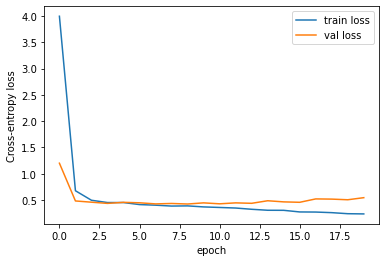

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

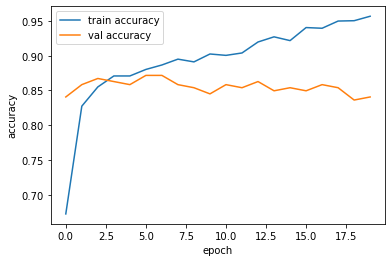

In [19]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [20]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 2ms/step - loss: 0.5184 - accuracy: 0.8406


[0.5183751583099365, 0.8406374454498291]

In [21]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good")

We had booked at this hotel 4 months in advance because TripAdvisor said this was the 1 hotel in Winnfield and honestly we did not even stay for 1 hour, we went to our room called La Jagu and moved to that hotel, please see my review of that hotel for information about it. When we arrived, the ladies at... More
Bad


In [22]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

[[0.02045111 0.97954893]]


'Good'

In [23]:
print(test_reviews.iloc[1])
print("Bad" if y_test[1][0] == 1 else "Good")

Clean friendly easy to access from the highway. Good price with Beautiful rooms. Free breakfast and free wifi. The staff were amazing! I called at 10:05pm had a room 3 mins later. I will definitely go back here!!!
Good
